In [4]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install tensorflow


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
import numpy as np
# funkcija za generiranje kugli
def generate_spheres(n):
    phi = np.random.uniform(0, 2 * np.pi, n)
    theta = np.random.uniform(0, np.pi, n)
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    return np.vstack((x, y, z)).T

n = 300

K1 = generate_spheres(n)
K2 = generate_spheres(n) +  2
K3 = generate_spheres(n) + 4


# povećavamo kompleksnost podatadaka dodavši 7 dimenzija na originalne tri, dakle radimo s 10 dimenzija 
data = np.vstack((K1, K2, K3))
noise = np.random.uniform(0, 1, (data.shape[0], 7))  
data_noisy = np.hstack((data, noise))

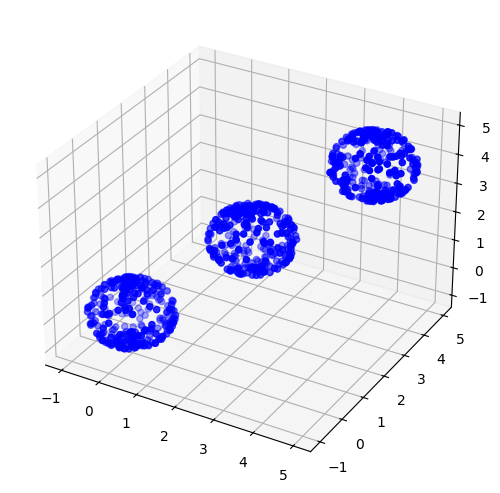

In [22]:
#vizualizacija originalnih podataka
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(28, 7))

ax1 = fig.add_subplot(141, projection='3d')
ax1.scatter(data[:, 0], data[:, 1], data[:, 2], color='blue', marker='o')

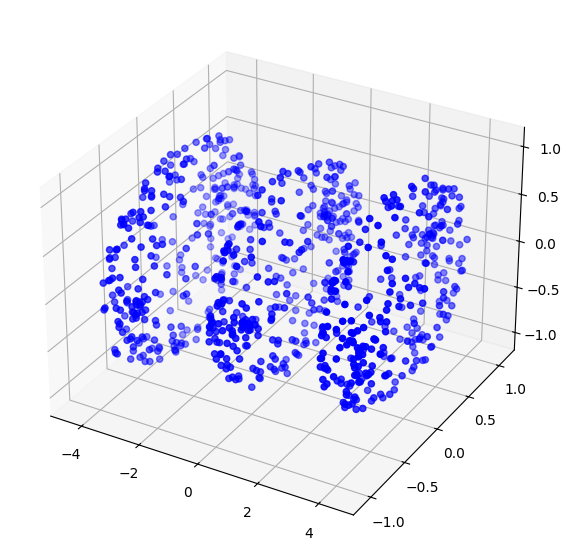

In [23]:
#PCA redukcija

from sklearn.decomposition import PCA

fig = plt.figure(figsize=(28, 7))

pca = PCA(n_components=3)
data_pca = pca.fit_transform(data_noisy)


ax1 = fig.add_subplot(111, projection='3d')
ax1.scatter(data_pca[:, 0], data_pca[:, 1], data_pca[:, 2], color='blue', marker='o')


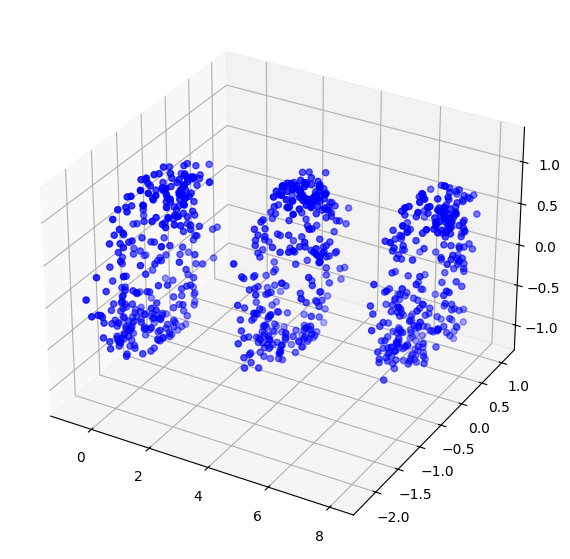

In [24]:
#SVD redukcija

fig = plt.figure(figsize=(28, 7))

U, S, VT = np.linalg.svd(data_noisy)
data_svd = U[:, :3] @ np.diag(S[:3])

ax1 = fig.add_subplot(133, projection='3d')
ax1.scatter(data_svd[:, 0], data_svd[:, 1], data_svd[:, 2], color='blue', marker='o')

In [15]:
# metric MDS pomoću neuronske mreže s jednim hidden layer-om 
import tensorflow as tf

class MDSNet(tf.keras.Model):
    def __init__(self, input_dim, output_dim):
        super(MDSNet, self).__init__()
        self.fc1 = tf.keras.layers.Dense(output_dim, activation='tanh')
    
    def call(self, x):
        return self.fc1(x)

input_dim = data_noisy.shape[1]
output_dim = 3
learning_rate = 0.001
batch_size = 256
epochs = 1000

model_mmds = MDSNet(input_dim, output_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate)

@tf.function
def train_step(batch_data):
    with tf.GradientTape() as tape:
        output = model_mmds(batch_data)
        distance_orig = tf.norm(tf.expand_dims(batch_data, 0) - tf.expand_dims(batch_data, 1), axis=-1)
        distance_proj = tf.norm(tf.expand_dims(output, 0) - tf.expand_dims(output, 1), axis=-1)
        loss = tf.reduce_mean(tf.square(distance_proj - distance_orig))
    gradients = tape.gradient(loss, model_mmds.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model_mmds.trainable_variables))
    return loss

data_noisy_tensor = tf.convert_to_tensor(data_noisy, dtype=tf.float32)

for epoch in range(epochs):
    permutation = np.random.permutation(data_noisy_tensor.shape[0])
    for i in range(0, data_noisy_tensor.shape[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_data = tf.gather(data_noisy_tensor, indices)
        loss = train_step(batch_data)
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss:.4f}')

data_mmds = model_mmds(data_noisy_tensor).numpy()



Epoch [100/1000], Loss: 6.9955
Epoch [200/1000], Loss: 5.8411
Epoch [300/1000], Loss: 6.1531
Epoch [400/1000], Loss: 4.9277
Epoch [500/1000], Loss: 5.4579
Epoch [600/1000], Loss: 5.6259
Epoch [700/1000], Loss: 4.8434
Epoch [800/1000], Loss: 5.1470
Epoch [900/1000], Loss: 5.1485
Epoch [1000/1000], Loss: 4.4458


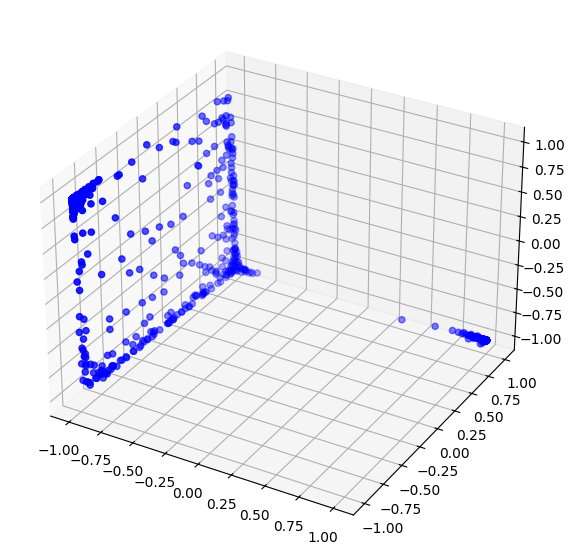

In [27]:
# Podaci nakon mMDS redukcije
fig = plt.figure(figsize=(28, 7))

ax1 = fig.add_subplot(111, projection='3d')
ax1.scatter(data_mmds[:, 0], data_mmds[:, 1], data_mmds[:, 2], color='blue', marker='o')


In [18]:
#Autoencoder redukcija dimenzija

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

input_layer = Input(shape=(data_noisy.shape[1],))
encoded = Dense(5, activation='relu')(input_layer)
encoded = Dense(3, activation='relu')(encoded)

decoded = Dense(5, activation='relu')(encoded)
decoded = Dense(data_noisy.shape[1], activation='sigmoid')(decoded)

autoencoder = Model(input_layer, decoded)
encoder = Model(input_layer, encoded)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(data_noisy, data_noisy, epochs=1000, batch_size=256, shuffle=True, verbose=0)

data_autoencoded = encoder.predict(data_noisy)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


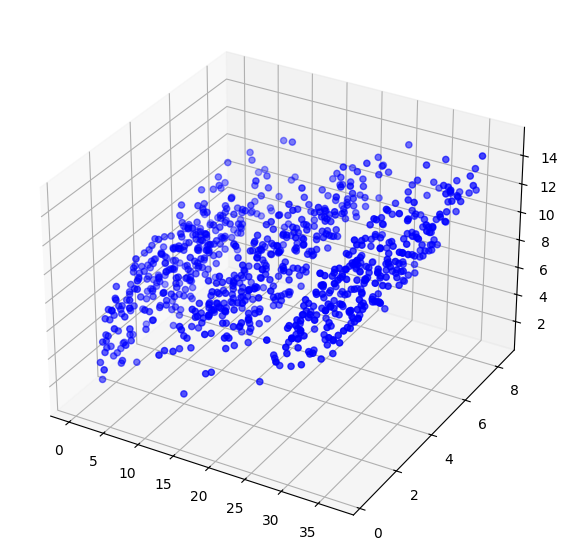

In [26]:
#  vizualizacija podataka nakon autoencodera
fig = plt.figure(figsize=(28, 7))

ax1 = fig.add_subplot(111, projection='3d')
ax1.scatter(data_autoencoded[:, 0], data_autoencoded[:, 1], data_autoencoded[:, 2], color='blue', marker='o')

